In [1]:
# import the necessary packages
import torch
import cv2
import os
import glob
import xml.etree.ElementTree as ET
import torchvision
os.getcwd()
# os.chdir('..')

'C:\\Users\\15856\\Data 690 AI\\Final Project'

In [2]:
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files
BASE_PATH = ""
IMAGES_PATH = os.path.sep.join([BASE_PATH, "collectedimgs"])
ANNOTS_PATH = os.path.sep.join([BASE_PATH, "annotations"])
# define the path to the base output directory
# os.mkdir("output")
# os.chdir('output')
# os.mkdir("plots")
# os.chdir('..')
BASE_OUTPUT = "output"
# define the path to the output model, label encoder, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector3.pth"])
LE_PATH = os.path.sep.join([BASE_OUTPUT, "le.pickle"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [3]:
# determine the current device and based on that set the pin memory
# flag
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False
# specify ImageNet mean and standard deviation
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-4
NUM_EPOCHS = 30
BATCH_SIZE = 16
# specify the loss weights
LABELS = 1.0
BBOX = 1.0

In [4]:
DEVICE

'cpu'

In [5]:
# import the necessary packages
from torch.utils.data import Dataset
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

In [6]:
from torch.nn import Dropout
from torch.nn import Identity
from torch.nn import Linear
from torch.nn import Module
from torch.nn import ReLU
from torch.nn import Sequential
from torch.nn import Sigmoid
from torch.nn import Flatten
import torch.nn as nn

class ObjectDetector(Module):
    def __init__(self, baseModel, numClasses):
        super(ObjectDetector, self).__init__()
        # initialize the base model and the number of classes
        self.baseModel = baseModel
        self.numClasses = numClasses
        # build the regressor head for outputting the bounding box
        # coordinates
        self.regressor = Sequential(
            Flatten(),
            Linear(2048, 128),
            ReLU(),
            Linear(128, 64),
            ReLU(),
            Linear(64, 32),
            ReLU(),
            Linear(32, 4),
            Sigmoid()
            )
        # build the classifier head to predict the class labels
        self.classifier = Sequential(
            Linear(2048, 512),
            ReLU(),
            Dropout(),
            Linear(512, 512),
            ReLU(),
            Dropout(),
            Linear(512, self.numClasses)
            )
        # set the classifier of our base model to produce outputs
        # from the last convolution block
        self.baseModel.fc = Identity()
    def forward(self, x):
    # pass the inputs through the base model and then obtain
    # predictions from two different branches of the network
        features = self.baseModel(x)
        bboxes = self.regressor(features)
        classLogits = self.classifier(features)
    # return the outputs as a tuple
        return (bboxes, classLogits)

In [7]:
!pip install imutils

In [8]:
# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torch.nn import MSELoss
from torch.optim import Adam
from torchvision.models import resnet50
from sklearn.model_selection import train_test_split
from imutils import paths
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import time
import cv2
import os
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
os.getcwd()

'C:\\Users\\15856\\Data 690 AI\\Final Project'

In [114]:
path = './Images'
xml_files = glob.glob(path+"/*.xml")
img_files = glob.glob(path+"/*.jpg")
len(img_files)

data = []
labels = []
bboxes = []
imagePaths = []

for i, file in enumerate(xml_files):
    root = ET.parse(file).getroot()
    xmin = int(root.find("object").find("bndbox").find("xmin").text)
    ymin = int(root.find("object").find("bndbox").find("ymin").text)
    xmax = int(root.find("object").find("bndbox").find("xmax").text)
    ymax = int(root.find("object").find("bndbox").find("ymax").text)
    class_name = root.find("object").find("name").text.lower()

    imagePath = img_files[i]
    image = cv2.imread(imagePath)
    (h,w)=image.shape[:2]

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    x_scale = ( 224 / w)
    y_scale = ( 224 / h)
    
    startx = int(xmin*x_scale)
    starty = int(ymin*y_scale)
    endx = int(xmax*x_scale)
    endy = int(ymax*y_scale)
    
    data.append(image)
    labels.append(class_name)
    bboxes.append((startx, starty, endx, endy))
    imagePaths.append(imagePath)
    
labels    

['a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'a',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'c',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'd',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'e',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'f',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'g',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'h',
 'hello',
 'hello',
 'hello',
 'hello',


In [115]:
#from the xml files I will extract the necessary bounding boxes to find my data
class SignLanguageData(torch.utils.data.Dataset):
    # initialize the constructor
    def __init__(self, tensors, transforms=None):
        self.tensors = tensors
        self.transforms = transforms
    def __getitem__(self, index):
        # grab the image, label, and its bounding box coordinates
        image = self.tensors[0][index]
        label = self.tensors[1][index]
        bbox = self.tensors[2][index]
        # transpose the image such that its channel dimension becomes
        # the leading one
        image = image.permute(2, 0, 1)
        # check to see if we have any image transformations to apply
        # and if so, apply them
        if self.transforms:
            image = self.transforms(image)
        # return a tuple of the images, labels, and bounding
        # box coordinates
        target = {}
        bbox = bbox.unsqueeze(0)
        target["boxes"] = bbox
        label = label.unsqueeze(0)
        target["labels"] = label
#         return (image, label, bbox)
        return image, target
    def __len__(self):
        # return the size of the dataset
        return self.tensors[0].size(0)

In [116]:
data = np.array(data, dtype="float32")
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)
# perform label encoding on the labels
le = LabelEncoder()
labels = le.fit_transform(labels)

In [117]:
split = train_test_split(data, labels, bboxes, imagePaths,
test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [118]:
(trainImages, testImages) = torch.tensor(trainImages),torch.tensor(testImages)
(trainLabels, testLabels) = torch.tensor(trainLabels),torch.tensor(testLabels)
(trainBBoxes, testBBoxes) = torch.tensor(trainBBoxes),torch.tensor(testBBoxes)

In [119]:
from torchvision import transforms

# transforms = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.Normalize(mean=MEAN, std=STD)
# ])

transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
#https://github.com/EdwardRaff/Inside-Deep-Learning/blob/main/Chapter_8.ipynb
def collate_fn(batch):
    """
    batch is going to contain a python list of objects. In our case, our data loader returns (Tensor, Dict) pairs
    The FasterRCNN algorithm wants a List[Tensors] and a List[Dict]. So we will use this function to convert the 
    batch of data into the form we want, and then give it to the Dataloader to use
    """
    imgs = []
    labels = []
    for img, label in batch:
        imgs.append(img)
        labels.append(label)
    return imgs, labels

In [120]:
trainDS = SignLanguageData((trainImages, trainLabels, trainBBoxes),transforms=transforms)
testDS = SignLanguageData((testImages, testLabels, testBBoxes),transforms=transforms)
print("[INFO] total training samples: {}...".format(len(trainDS)))
print("[INFO] total test samples: {}...".format(len(testDS)))
# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // BATCH_SIZE
valSteps = len(testDS) // BATCH_SIZE
# create data loaders
trainLoader = DataLoader(trainDS, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, pin_memory=PIN_MEMORY)
testLoader = DataLoader(testDS, batch_size=BATCH_SIZE, collate_fn=collate_fn,  pin_memory=PIN_MEMORY)

[INFO] total training samples: 544...
[INFO] total test samples: 137...


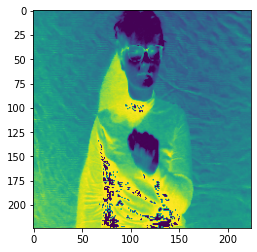

In [121]:
from matplotlib.pyplot import imshow
x, y = trainDS[0] # Grab an image with its labels
imshow(x.numpy()[0,:])

In [122]:
print(y) #prints out everything
print("Boxes: ", y['boxes']) #prints a tensor showing the pixel locations of the corners for all 3 objects
print("Labels: ", y['labels'])

{'boxes': tensor([[ 94., 117., 137., 175.]]), 'labels': tensor([24])}
Boxes:  tensor([[ 94., 117., 137., 175.]])
Labels:  tensor([24])


In [123]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'hello': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'my': 14, 'n': 15, 'name': 16, 'no': 17, 'o': 18, 'p': 19, 'project': 20, 'q': 21, 'r': 22, 's': 23, 't': 24, 'thank you': 25, 'this': 26, 'u': 27, 'v': 28, 'w': 29, 'x': 30, 'y': 31, 'yes': 32, 'z': 33}


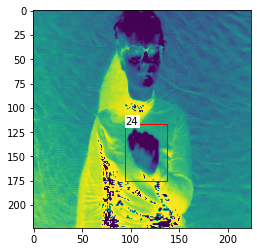

In [124]:
import matplotlib.patches as patches
def plotDetection(ax, abs_pos, label=None):
    """
    ax: the matpllib axis to add this plot to
    abs_pos: the positions of the bounding box
    label: the label of the prediction to add
    """
    x1, y1, x2, y2 = abs_pos
    #make a rectangle for the bounding box
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    #add the label if given
    if label is not None:
        plt.text(x1+0.5, y1, label, color='black', bbox=dict(facecolor='white', edgecolor='white', pad=1.0))
    
    return 
fig,ax = plt.subplots(1)
ax.imshow(x.numpy()[0,:])
plotDetection(ax, y['boxes'][0], y['labels'][0].item())

In [125]:
print("[INFO] saving testing image paths...")
f = open(TEST_PATHS, "w")
f.write("\n".join(testPaths))
f.close()
# load the ResNet50 network
# resnet = resnet50(pretrained=True)
rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# freeze all ResNet50 layers so they will *not* be updated during the
# training process
for param in rcnn.parameters():
    param.requires_grad = False

# modelOutputFeats = model.fc.in_features
# model.fc = nn.Linear(modelOutputFeats, len(trainDS.classes))
# model = model.to(DEVICE)
    

[INFO] saving testing image paths...


In [126]:
#How many channels are in the input?
C = 3
#How many classes are there?
classes = 34
#How many filters in our backbone
n_filters = 32

In [127]:
#Define our helper function that creates a hidden layer for a CNN
def cnnLayer(in_filters, out_filters, kernel_size=3):
    """
    in_filters: how many channels are in the input to this layer
    out_filters: how many channels should this layer output
    kernel_size: how large should the filters of this layer be
    """
    padding = kernel_size//2
    return nn.Sequential(
        nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
        nn.BatchNorm2d(out_filters),
        nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
    )

def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

In [128]:
backbone = nn.Sequential(
    cnnLayer(C, n_filters),    
    cnnLayer(n_filters, n_filters),
    cnnLayer(n_filters, n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    cnnLayer(2*n_filters, 2*n_filters),
    nn.MaxPool2d((2,2)),
    cnnLayer(2*n_filters, 4*n_filters),
    cnnLayer(4*n_filters, 4*n_filters),
)
#Let Faster RCNN know exactly how many output channels to expect
backbone.out_channels = n_filters*4

In [129]:
# How many proposals $k$ should be generated? Every aspect ration will be one, and the process will be repeated for multiple image sizes 
anchor_generator = AnchorGenerator(sizes=((224),), aspect_ratios=((1.0),)) #To make this run faster, we are telling PyTorch to look for only square images that are 32 x 32 in size

#Tell PyTorch to use the final output of the backbone as the featuremap (['0']), use adaptive pooling down to a 7x7 grid (output_size=7)
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)
#sampling_ratio is poorly named, and controls details on how the RoI grabs slices of the feature map when a fractional pixel location is predicted (e.g., 5.8 instead of 6). We are not going to go into those low level details, 2 is a reasonable default for most work. 
        
#Now we can create the FasterRCNN object. We give it the backbone network, number of classes, min & max size to process images at (we know all our images at 100 pixels), a mean and standard deviation to subtract from the images, and the anchor generation (RPN) and RoI objects
model = FasterRCNN(backbone, num_classes=classes, image_mean = (0.5,), image_std = (0.5,), min_size=100, max_size=100, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler)


In [130]:
model = model.train()
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters())

for epoch in tqdm(range(1), desc="Epoch", disable=False):
    running_loss = 0.0
    for inputs, labels in tqdm(trainLoader, desc="Train Batch", leave=False, disable=False):
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, DEVICE)
        labels = moveTo(labels, DEVICE)

        optimizer.zero_grad()
        #rcnn wants model(inputs, labels) - not just model(inputs)
        losses = model(inputs, labels)
        # Compute loss, RCNN gives us a list of losses to add up.
        loss = 0
        for partial_loss in losses.values():
            loss += partial_loss
        #now proceed like normal
        loss.backward()
        
        optimizer.step()

        running_loss += loss.item()

Epoch: 100%|██████████| 1/1 [05:40<00:00, 340.48s/it]       


In [135]:
# objectDetector = ObjectDetector(rcnn, len(le.classes_))
# objectDetector = objectDetector.to(DEVICE)
# # define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# # initialize the optimizer, compile the model, and show the model
# # summary
opt = Adam(model.parameters(), lr=INIT_LR)
# print(objectDetector)
# # initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],"val_class_acc": []}

In [146]:
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(1)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    for inputs, labels in trainLoader:
        #Move the batch to the device we are using. 
        inputs = moveTo(inputs, DEVICE)
        labels = moveTo(labels, DEVICE)
        # perform a forward pass and calculate the training loss
        predictions = model(inputs, labels)
        print(predictions)
        proposal_losses = {}
        proposal_losses = {
        "loss_objectness": predictions['loss_objectness'],
        "loss_rpn_box_reg":  predictions['loss_rpn_box_reg'],
        }
        detector_losses = {}
        detector_losses = {
            "loss_classifier": predictions['loss_classifier'], 
            "loss_box_reg": predictions['loss_box_reg']
        }
        
        losses = {}
        losses.update(detector_losses)
        losses.update(proposal_losses)
        
#         bboxLoss = predictions['loss_box_reg'] + predictions['loss_classifier']
#         classLoss = predictions['loss_objectness'] + predictions['loss_rpn_box_reg']
#         totalLoss = (BBOX * bboxLoss) + (LABELS * classLoss)
        totalLoss = sum(loss for loss in losses.values())
        # zero out the gradients, perform the backpropagation step,
        # and update the weights
        opt.zero_grad()
        totalLoss.backward()
        opt.step()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += totalLoss
#         trainCorrect += (predictions[1].argmax(1) == labels).type(
#             torch.float).sum().item()
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for inputs, labels in testLoader:
            # send the input to the device
            inputs = moveTo(inputs, DEVICE)
            labels = moveTo(labels, DEVICE)
            # make the predictions and calculate the validation loss
            predictions = model(inputs, labels)
#             bboxLoss = predictions['loss_box_reg'] + predictions['loss_classifier']
#             classLoss = predictions['loss_objectness'] + predictions['loss_rpn_box_reg']
#             totalLoss = (BBOX * bboxLoss) + \
#                 (LABELS * classLoss)
            proposal_losses = {}
            proposal_losses = {
            "loss_objectness": predictions['loss_objectness'],
            "loss_rpn_box_reg":  predictions['loss_rpn_box_reg'],
            }
            detector_losses = {}
            detector_losses = {
                "loss_classifier": predictions['loss_classifier'], 
                "loss_box_reg": predictions['loss_box_reg']
            }

            losses = {}
            losses.update(detector_losses)
            losses.update(proposal_losses)

            totalLoss = sum(loss for loss in losses.values())
            totalValLoss += totalLoss
            # calculate the number of correct predictions
#             valCorrect += (predictions[].argmax(1) == labels['labels']).type(
#                 torch.float).sum().item()
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
#     trainCorrect = trainCorrect / len(trainDS)
#     valCorrect = valCorrect / len(testDS)
    # update our training history
    H["total_train_loss"].append(avgTrainLoss.cpu().detach().numpy())
#     H["train_class_acc"].append(trainCorrect)
    H["total_val_loss"].append(avgValLoss.cpu().detach().numpy())
#     H["val_class_acc"].append(valCorrect)
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
    print("Train loss: {:.6f}".format(
        avgTrainLoss ))
    print("Val loss: {:.6f}".format(
        avgValLoss))
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))


[INFO] training the network...


  0%|          | 0/1 [00:00<?, ?it/s]

{'loss_classifier': tensor(0.1678, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0993, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0082, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.3656, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.1555, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0890, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0081, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.4218, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.1399, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0747, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0082, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.4148, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.1596, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0966, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0081, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'los

{'loss_classifier': tensor(0.1867, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.1120, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0087, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.2857, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.1669, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0947, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0742, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.3498, grad_fn=<DivBackward0>)}


  0%|          | 0/1 [04:05<?, ?it/s]


TypeError: list indices must be integers or slices, not str

In [ ]:
# serialize the model to disk
print("[INFO] saving object detector model...")
torch.save(objectDetector, MODEL_PATH)
# serialize the label encoder to disk
print("[INFO] saving label encoder...")
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["total_train_loss"], label="total_train_loss")
plt.plot(H["total_val_loss"], label="total_val_loss")
plt.plot(H["train_class_acc"], label="train_class_acc")
plt.plot(H["val_class_acc"], label="val_class_acc")
plt.title("Total Training Loss and Classification Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# save the training plot
plotPath = os.path.sep.join([PLOTS_PATH, "training.png"])
plt.savefig(plotPath)

In [ ]:
def print_dataloader_attributes(dataloader):
    """
    https://stackoverflow.com/questions/1547466/check-if-a-parameter-is-a-python-module
    
    :param dataloader:
    :return:
    """
    from types import ModuleType
    import inspect

    for attribute in dir(dataloader):
        attribute_value = getattr(dataloader, attribute)
#         print(f'{attribute=}, {type(attribute_value)=}\n')
        if isinstance(attribute_value, ModuleType) or inspect.ismodule(attribute_value) or type(attribute_value) is type(inspect):
            print(attribute_value)
    print('')

In [ ]:
print_dataloader_attributes(trainLoader)

In [ ]:
!pip install optuna

In [ ]:
objectDetector = ObjectDetector(resnet, len(le.classes_))
objectDetector = objectDetector.to(DEVICE)
# define our loss functions
classLossFunc = CrossEntropyLoss()
bboxLossFunc = MSELoss()
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(objectDetector.parameters(), lr=INIT_LR)
print(objectDetector)
# initialize a dictionary to store training history
H = {"total_train_loss": [], "total_val_loss": [], "train_class_acc": [],"val_class_acc": []}

In [ ]:
# Optimize
import optuna

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler())


def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'batch_size': trial.suggest_int("batch_size", 8, 16, 32, 64)
              }
    
    model = build_model(params)
    
    accuracy = train_and_evaluate(params, model)

    return accuracy


study.optimize(objective, n_trials=50)